# Visualize the trajectory of a cluster

In [1]:
import json, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tool_create_substrate import particle_en_gaussian, particle_en_tan, calc_matrices_square, calc_matrices_triangle
from tool_create_cluster import rotate, create_cluster
fdir="./comm/" # Commensurate R=4.45 triangular substrate
# fdir="./" # Incommensurate R=5 square substrate
outfname="out-MD.dat"
infofname='info-MD_rigid_rototrasl.json'

### Load MD output
Info ```.json``` contains useful information on system to automatically setup analysis.
Real MD results are in fix-width-columns file ```.dat```.

In [2]:
with open(os.path.join(fdir,infofname), 'r') as inj:
    info = json.load(inj)
N = info['N']
R = info['R']
epsilon = info['epsilon']
if info['sub_symm'] == 'triangle': u, u_inv = calc_matrices_triangle(R)
elif info['sub_symm'] == 'square': u, u_inv = calc_matrices_square(R)
else: raise ValueError('This is not the symmetry you are looking for (%s)' %  info['sub_symm'])
if info['well_shape'] == 'tanh':
    # Realistic well energy landscape
    calc_en_f = particle_en_tan
    a = info['a'] # Well end radius [micron]
    b = info['b'] # Well slope radius [micron]
    wd = info['wd'] # Well asymmetry. 0.29 is a good value
    en_params = [a, b, wd, epsilon, u, u_inv]
elif info['well_shape'] == 'gaussian':
    # Gaussian energy landscape
    calc_en_f = particle_en_gaussian
    sigma = info['sigma'] # Width of Gaussian
    en_params = [sigma, epsilon, u, u_inv]
else:
    raise ValueError("Form %s not implemented" % well_shape)
    
data = pd.read_fwf(os.path.join(fdir,outfname), infer_nrows=1e30)
pos = create_cluster(info['cluster_hex'])
for k,v in info.items():
    print("%12s:" %k, v)
    
data.head()

         eta: 1
    etat_eff: 127
    etar_eff: 44080.365
      brandt: 32.15165936619757
      brandr: 598.9962762438511
           N: 127
   theta_max: 1e+30
  print_skip: 200
  min_Nsteps: 1e+30
      avglen: 100
   omega_min: -1
   omega_max: 1e+30
      pos_cm: [0.0, 0.0]
       angle: 0
       sigma: 0.5
           a: 0.6
           b: 2.0
          wd: 0.29
          dt: 0.0001
     epsilon: 105
    sub_symm: triangle
  well_shape: gaussian
           R: 4.45
      Nsteps: 300000
 cluster_hex: input_hex-Nl_7.hex
 both_breaks: False
           T: 4.0698
         Tau: 300000.0
          Fx: 0.0
          Fy: 0.0


,#00)dt*it,01)e_pot,02)pos_cm[0],03)pos_cm[1],04)Vcm[0],05)Vcm[1],06)angle,07)omega,08)forces[0],09)forces[1],10)torque
0,0.00,-13335.000000,0.000000,0.000000,-0.373498,-0.220060,0.000000,6.787628,-1.594631e-10,-2.264231e-11,-1.218770e-10
1,0.02,-13289.847420,-0.000046,-0.000100,-0.112252,0.033021,0.126684,5.883258,2.420078e+00,5.302685e+00,-4.074978e+04
2,0.04,-13178.794597,0.000144,0.000105,0.310616,-0.376580,0.236291,5.108263,-7.494905e+00,-5.485403e+00,-7.515784e+04
3,0.06,-13029.630499,-0.000087,-0.000044,0.106724,-0.003576,0.331638,4.425163,4.417598e+00,2.215900e+00,-1.038884e+05
4,0.08,-12860.842481,-0.000053,-0.000037,-0.017734,0.111001,0.415053,3.889158,2.648978e+00,1.849723e+00,-1.277625e+05


### Plot trajectory of CM and energy as function of time

Draw the trajectory of the cluster in $xy$ plane.
Color each point with orientation of cluster.
Represents all degrees of fredom!

Overlay on substrate potential: contour of few lines, just to spot the lattice points and near-flat regions.

On the right, plot energy as function of time.
Color each point with angle as well to easy spot CM trajectory-energy correlation.

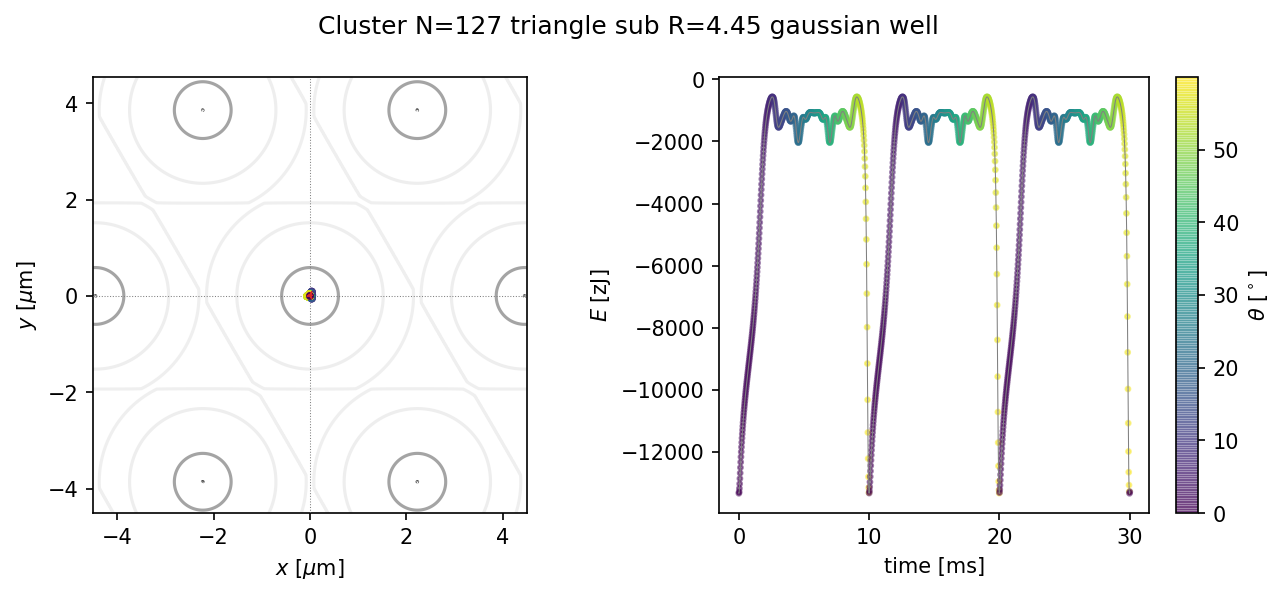

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML

# --- DEFINE PLOT ---
fig, (ax, ax_en) = plt.subplots(1,2, figsize=(9,4), dpi=150)
fig.suptitle("Cluster N=%i %s sub R=%.3g %s well" % (N, info['sub_symm'], R, info['well_shape']))

# --- CREATE SUBSTRATE ---
if info['sub_symm'] == 'triangle': u, u_inv = calc_matrices_triangle(R)
elif info['sub_symm'] == 'square': u, u_inv = calc_matrices_square(R)
else: raise ValueError('This is not the symmetry you are looking for (%s)' %  info['sub_symm'])

sub_dens = 1000
max_r = np.linalg.norm(pos,axis=1)
max_r = np.max(max_r)

xmin, xmax = min(data['02)pos_cm[0]'])-R, max(data['02)pos_cm[0]']+R)
ymin, ymax = min(data['03)pos_cm[1]'])-R, max(data['03)pos_cm[1]']+R)
xx, yy = np.linspace(xmin, xmax, sub_dens), np.linspace(ymin, ymax, sub_dens)
sub_pos = np.array([[x,y] for y in yy for x in xx ]) # inner x outer y, to integrate easier with meshgrid
sub_gx, sub_gy = np.meshgrid(xx, yy)

# --- PLOT SUB ---
contour = ax.contour(sub_gx, sub_gy, np.reshape(calc_en_f(sub_pos, (0,0), *en_params)[0], (xx.shape[0],xx.shape[0])),
                      [-epsilon+epsilon/1e4, -epsilon/2, -epsilon/100, -epsilon/1e4], # Contour levels
                      cmap='Greys_r', linewidths=1.5, alpha=0.7, vmin=-epsilon, vmax=epsilon/5 # Adjust to get decent contrast!
                     )

# --- PLOT COSMETICS ---
ax.axhline(zorder=4, color="gray", lw=0.5, ls=':')
ax.axvline(zorder=4, color="gray", lw=0.5, ls=':')
ax.set_xlabel(r"$x$ [$\mu$m]")
ax.set_ylabel(r"$y$ [$\mu$m]")
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_aspect('equal')

clab = r"$\theta$ [$^\circ$]"
c = data['06)angle'] % 60

# Left plot CM xy trajectory
sc = ax.scatter(data['02)pos_cm[0]'], data['03)pos_cm[1]'], c=c, s=8, alpha=0.8, zorder=10, facecolors='none')
ax.plot(data['02)pos_cm[0]'], data['03)pos_cm[1]'], color='tab:red', lw=0.7, zorder=11)
# Energy
x = data['#00)dt*it']
y = data['01)e_pot']
ax_en.plot(x, y, '-', color='gray', lw=0.5)
sc = ax_en.scatter(x, y, c=c, s=5, alpha=0.5)
cbar = plt.colorbar(sc)
cbar.set_label(clab)
ax_en.set_xlabel('time [ms]')
ax_en.set_ylabel(r"$E$ [zJ]")

plt.tight_layout()
plt.show()

### Load static map 

Energy as a function of rotation angle, static calculation.

In [4]:
outfname="out-rotomap_Nl_7.dat"
data_static = pd.read_fwf(os.path.join(fdir,outfname), infer_nrows=1e30)
data_static.head()

,#00)theta,01)e_pot,02)forces[0],03)forces[1],04)torque
0,-31.00,-1073.386672,-9.230394e-13,2.663980e-13,716.189555
1,-30.99,-1073.511492,-6.443734e-13,-2.464695e-14,714.126121
2,-30.98,-1073.635941,-9.787726e-13,-9.897361e-13,711.932621
3,-30.97,-1073.759996,-5.622169e-13,-5.651035e-13,709.608550
4,-30.96,-1073.883634,-1.342038e-12,-4.487799e-13,707.153377


## Compare MD and static

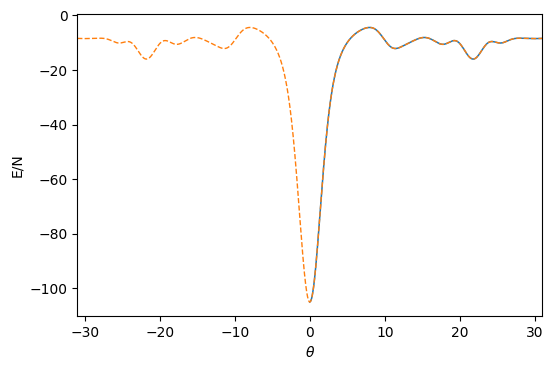

In [5]:
plt.plot(data['06)angle'], data['01)e_pot']/N, label='MD', lw=1.1)
plt.plot(data_static['#00)theta'], data_static['01)e_pot']/N, '--', lw=1, label='static')
plt.xlim(data_static['#00)theta'].min(), data_static['#00)theta'].max())
plt.xlabel(r'$\theta$')
plt.ylabel('E/N')
plt.gcf().set_dpi(100)
plt.show()

## Movie time

To please the eye, and get a bit of a feeling of how the Moire' pattern is governing the system, plot the full cluster as it moves, coloring each colloid according to substrate position.

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML

# --- DEFINE PLOT ---
fig, (ax, ax_en) = plt.subplots(1,2, figsize=(9,4), dpi=150)
fig.suptitle("Cluster N=%i %s sub R=%.3g" % (N, info['sub_symm'], R))
# Text with progress
info_template = r"t=%5i ms (x,y)=(%5.2g, %5.2g) $\mu$m $\theta=%3.2g^\circ$"

# --- PLOT COSMETICS ---
xmin, xmax = min(data['02)pos_cm[0]'])-R-max_r, max(data['02)pos_cm[0]']+R+max_r)
ymin, ymax = min(data['03)pos_cm[1]'])-R-max_r, max(data['02)pos_cm[0]']+R+max_r)
ax.axhline(zorder=4, color="gray", lw=0.5, ls=':')
ax.axvline(zorder=4, color="gray", lw=0.5, ls=':')
ax.set_xlabel(r"$x$ [$\mu$m]")
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_ylabel(r"$y$ [$\mu$m]")
ax.set_aspect('equal')

ax_en.set_xlabel(r'Time $t$ [ms]')
ax_en.set_ylabel(r'Energy $E/N$ [zJ]')
ax_en.set_xlim([data['#00)dt*it'].min(),data['#00)dt*it'].max()])
ax_en.set_ylim([data['01)e_pot'].min()/N,data['01)e_pot'].max()/N])

# --- PLOT SUB ---
xx, yy = np.linspace(xmin, xmax, sub_dens), np.linspace(ymin, ymax, sub_dens)
sub_pos = np.array([[x,y] for y in yy for x in xx ]) # inner x outer y, to integrate easier with meshgrid
sub_gx, sub_gy = np.meshgrid(xx, yy)
contour = ax.contour(sub_gx, sub_gy, np.reshape(calc_en_f(sub_pos, (0,0), *en_params)[0], (xx.shape[0],xx.shape[0])),
                     [-epsilon+epsilon/1e4, -epsilon/2, -epsilon/100, -epsilon/1e4], 
                     cmap='Greys_r', linewidths=1.0, alpha=0.7, vmin=-epsilon, vmax=epsilon/5 # Adjust to get decent contrast!
                     )

# --- INIT CLUSTER PLOT ---
i = 0
pos0 = create_cluster(info['cluster_hex'], angle=0)[:,:2]
pos = pos0.copy()
t_l, en_l = [], []
t, en = data['#00)dt*it'].iloc[i], data['01)e_pot'].iloc[i]
t_l.append(t)
en_l.append(en)
cm_xtraj, cm_ytraj, cm_thtraj = [], [], []
cm_shift, angle = np.array([data['02)pos_cm[0]'].iloc[i], data['03)pos_cm[1]'].iloc[i]]), data['06)angle'].iloc[i]
cm_xtraj.append(cm_shift[0])
cm_ytraj.append(cm_shift[1])
cm_thtraj.append(angle)

# -- PLOT EN --
en_plt, = ax_en.plot(t_l, np.array(en_l)/N, '.-', color='tab:blue')

# --- PLOT CLUSTER ---
pltsc_params = {'vmin': -epsilon, 'vmax': 0, 'cmap': 'terrain',
                's': 150, 'edgecolors': 'black', 'lw': 0.5, 'alpha': 0.8,
                'zorder': 10}
pos = rotate(pos, angle=angle) + cm_shift
sc = ax.scatter(pos[:,0], pos[:,1], c=calc_en_f(pos, (0,0), *en_params)[0], **pltsc_params)
cbar = fig.colorbar(sc)
cbar.set_label(r'$E(x, y)$ [zJ]')    

# CM xy trajectory
line, = ax.plot([], [], '.-', color='tab:red', lw=2, zorder=30)
info_text = ax.text(0.05, 1.01, info_template % (t, *cm_shift, angle), transform=ax.transAxes)
# Cluster orientation
arrow = np.array([np.cos(angle*pi/180), np.sin(angle*pi/180)])
arrow = arrow*max_r*0.9/np.linalg.norm(arrow)
qv = ax.quiver(cm_shift[0], cm_shift[1], *arrow,
               color='tab:orange', linewidths=0.8, units='xy', angles='xy', scale=1, scale_units='xy', zorder=40)

def animate(i):
    global sc
    if int(i/skip) % print_skip == 0:
        print('Rendering %i%%' % (i/len(data)*100), file=sys.stderr)
    t, en = data['#00)dt*it'].iloc[i], data['01)e_pot'].iloc[i]
    t_l.append(t)
    en_l.append(en)
    cm_shift, angle = np.array([data['02)pos_cm[0]'].iloc[i], data['03)pos_cm[1]'].iloc[i]]), data['06)angle'].iloc[i] 
    cm_xtraj.append(cm_shift[0])
    cm_ytraj.append(cm_shift[1])
    cm_thtraj.append(angle)
    # Get cluster positions
    pos = create_cluster(info['cluster_hex'], angle=angle)[:,:2] + cm_shift
    # -- UPDATE EN --
    en_plt.set_data([t_l, np.array(en_l)/N])    
    # -- UPDATE TEXT --
    info_text.set_text(info_template % (t, *cm_shift, angle))
    # -- UPDATE CM XY --
    line.set_data([cm_xtraj,cm_ytraj]) #, c='tab:red', zorder=20)
    # -- UPDATE CM THETA --
    arrow = np.array([np.cos(angle*pi/180), np.sin(angle*pi/180)])
    arrow = arrow*max_r/np.linalg.norm(arrow)
    qv.set_offsets(cm_shift)
    qv.set_UVC(arrow[0], arrow[1])
    # -- UPDATE CLUSTER --
    sc.set_offsets(pos)
    sc.set_array(calc_en_f(pos, (0,0), *en_params)[0])
    
    return line, qv, sc

t0 = time()
skip = 50
print_skip = np.floor(len(data)/skip/10)
ani = animation.FuncAnimation(fig, animate, range(0, len(data), skip), interval=200, blit=True)
plt.tight_layout()

# Embedded video with controllers
matplotlib.rcParams['animation.embed_limit'] = 300 # Max size of embedded movie, in MB
HTML(ani.to_jshtml())

# Save the animation
# name = "movie-N_%i-%s_%.3g.mp4" % (N, info['sub_symm'], info['R'])
# writer = animation.FFMpegWriter(
#     fps=5, metadata=dict(artist='Me'), bitrate=2200)
# ani.save(name, writer=writer)

# t_exec = time()-t0
# print("Done in %is (%.2fmin)" % (t_exec, t_exec/60))